# VTIimplementation

First of all, it is necessary to import some Devito modules and other packages that will be used in the implementation.

In [101]:
import numpy as np
from devito import (Function, TimeFunction, cos, sin, solve,
                    Eq, Operator, configuration, norm)
from examples.seismic import TimeAxis, RickerSource, Receiver, demo_model
from examples.seismic.model import SeismicModel
from matplotlib import pyplot as plt

In [102]:
# NBVAL_IGNORE_OUTPUT   

shape   = (601,601) 
spacing = (10.,10.) # spacing of 10 meters
origin  = (0.,0.)  
nbl = 0  # number of pad points
sorder=8
torder=2

# model = demo_model('layers-tti', spacing=spacing, space_order=2,
#                   shape=shape, nbl=nbl, nlayers=1)

# # initialize Thomsem parameters to those used in Mu et al., (2020)
# model.update('vp', np.ones(shape)*3) # km/s
# model.update('epsilon', 0)#.23)
# model.update('delta', 0)#*0.17)
# # model.update('theta', np.ones(shape)*(45.*(np.pi/180.))) # radians
# model.update('theta', 0) # radians
vp = 3
eps =0.1#24
delt=0.1
#sigma = (vp*vp)/(vs*vs)*(epsilon - delta)
sigma = 6#float('inf')
vs2 = (vp*vp)*(eps - delt)/(sigma)
vti_f = 1 - (eps - delt)/(sigma)

freq_rickers = 0.005
freq = freq_rickers * 2.5


model = SeismicModel(space_order=sorder, vp=vp, origin=origin, shape=shape,
                      dtype=np.float32, spacing=spacing, nbl=nbl, epsilon=eps,
                      delta=delt, theta=0., phi=None, bcs="damp")




In [103]:
# Get symbols from model
theta = model.theta
delta = model.delta
epsilon = model.epsilon
m = model.m


In [104]:
# Compute the dt and set time range
t0 = 0.   #  Simulation time start
tn = 2000. #  Simulation time end (0.15 second = 150 msec)
dt = model.critical_dt
# dt = (dvalue/(np.pi*vmax))*np.sqrt(1/(1+etamax*(max_cos_sin)**2)) # eq. above (cell 3)
time_range = TimeAxis(start=t0,stop=tn,step=dt)
print("time_range; ", time_range)

time_range;  TimeAxis: start=0, stop=2000.59, step=1.579, num=1268


In [105]:
# NBVAL_IGNORE_OUTPUT

# time stepping 
p = TimeFunction(name="p", grid=model.grid, time_order=torder, space_order=sorder, save=time_range.num)
q = TimeFunction(name="q", grid=model.grid, time_order=torder, space_order=sorder) # space order 4?

#Fletcher
# fm1 = -(eps - delta)/sigma = vti_f - 1
# term1_p_f = (1 + 2*epsilon)*(p.dx2) + q.dy2 - fm1*(p.dy2-q.dy2)
# term1_q_f = (1 + 2*delta)*(p.dx2)   + q.dy2 + fm1*(p.dx2-q.dx2)

# Main equations
term_p = (1 + 2*epsilon)*(p.dx2) + q.dy2 - (vti_f - 1)*(p.dy2 - q.dy2)
term_q = (1 + 2*delta)*(p.dx2)   + q.dy2 + (vti_f - 1)*(p.dx2 - q.dx2)


stencil_p = solve(m*p.dt2 - term_p, p.forward)
update_p = Eq(p.forward, stencil_p)

stencil_q = solve(m*q.dt2 - term_q, q.forward)
update_q = Eq(q.forward, stencil_q)

# set source and receivers
src = RickerSource(name='src',grid=model.grid,f0=freq,npoint=1,time_range=time_range)
src.coordinates.data[:,0] = model.domain_size[0]* .5
src.coordinates.data[:,1] = model.domain_size[1]* .5
# Define the source injection
src_term = src.inject(field=p.forward,expr=src * dt**2 / m)
src_term_q = src.inject(field=q.forward,expr=src * dt**2 / m)

rec  = Receiver(name='rec',grid=model.grid,npoint=shape[0],time_range=time_range)
rec.coordinates.data[:, 0] = np.linspace(model.origin[0],model.domain_size[0], num=model.shape[0])
rec.coordinates.data[:, 1] = 2*spacing[1]
# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=p.forward)

# Operators
optime=Operator([update_p] + [update_q] + src_term  + src_term_q+rec_term)

# you can print the generated code for both operators by typing print(optime) and print(oppres)

In [106]:
optime(time=time_range.num-2, dt=model.critical_dt)

# NBVAL_IGNORE_OUTPUT
# psave =np.empty ((time_range.num,model.grid.shape[0],model.grid.shape[1]))
# niter_poisson = 1200


# This is the time loop.
# for step in range(0,time_range.num-2):
#     optime(time_m=step, time_M=step, dt=dt)
# #    q.data[:,:]=pp.data[(niter_poisson+1)%2,:,:]
# #    optime(time_m=step, time_M=step, dt=dt)
# #    pp.data[:,:]=0.
# #    b.data[:,:]=p.data[(step+1)%3,:,:]
# #    oppres(time_M = niter_poisson)
#     psave[step,:,:]=p.data[(step+1)%3,:,:]

Operator `Kernel` ran in 0.58 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.562847, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.00020799999999999953, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.011618999999999968, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [107]:
# Some useful definitions for plotting if nbl is set to any other value than zero
nxpad,nzpad = shape[0] + 2 * nbl, shape[1] + 2 * nbl
shape_pad   = np.array(shape) + 2 * nbl
origin_pad  = tuple([o - s*nbl for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

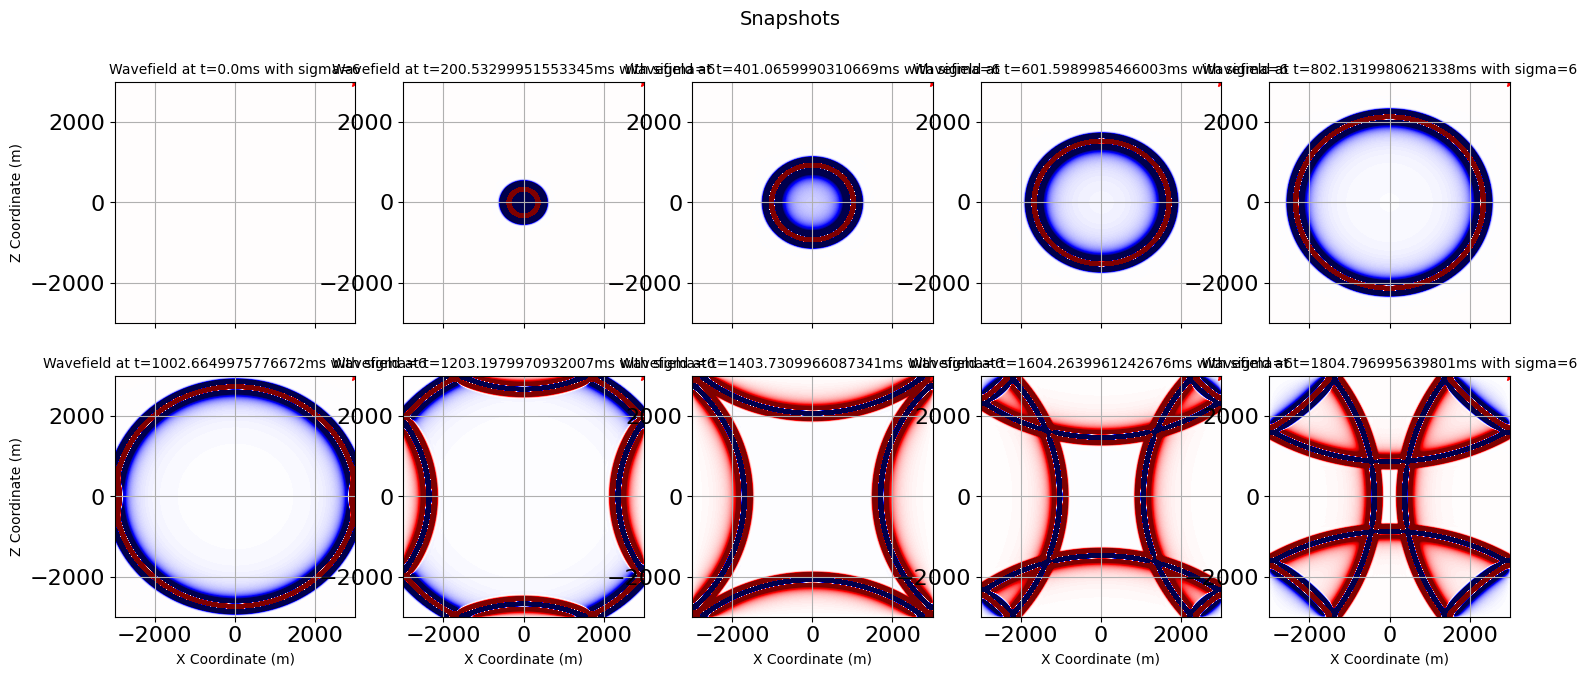

In [108]:
# NBVAL_IGNORE_OUTPUT

# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0] - extent_pad[0]/2, origin_pad[0] + extent_pad[0]/2,
              origin_pad[1] - extent_pad[1]/2, origin_pad[1] + extent_pad[1]/2]

# Plot the wavefields, each normalized to scaled maximum of last time step
kt = (time_range.num - 2) - 1
amax = 0.05 * np.max(np.abs(p.data[kt,:,:]))

nsnaps = 10
factor = round(time_range.num/nsnaps)

fig, axes = plt.subplots(2, 5, figsize=(18, 7), sharex=True)
fig.suptitle("Snapshots", size=14)
for count, ax in enumerate(axes.ravel()):
    snapshot = factor*count
    ax.imshow(np.transpose(p.data[snapshot,:,:]), cmap="seismic",
               vmin=-amax, vmax=+amax, extent=plt_extent)
    ax.plot(model.domain_size[0]* .5, model.domain_size[1]* .5, \
         'red', linestyle='None', marker='*', markersize=8, label="Source")
    ax.grid()
#    ax.tick_params('both', length=2, width=0.5, which='major',labelsize=10)
    ax.set_title("Wavefield at t="+str(factor*count*dt)+"ms with sigma="+str(sigma),fontsize=10)
for ax in axes[1, :]:
    ax.set_xlabel("X Coordinate (m)",fontsize=10)
for ax in axes[:, 0]:
    ax.set_ylabel("Z Coordinate (m)",fontsize=10)



Text(0, 0.5, 'Z Coordinate (m)')

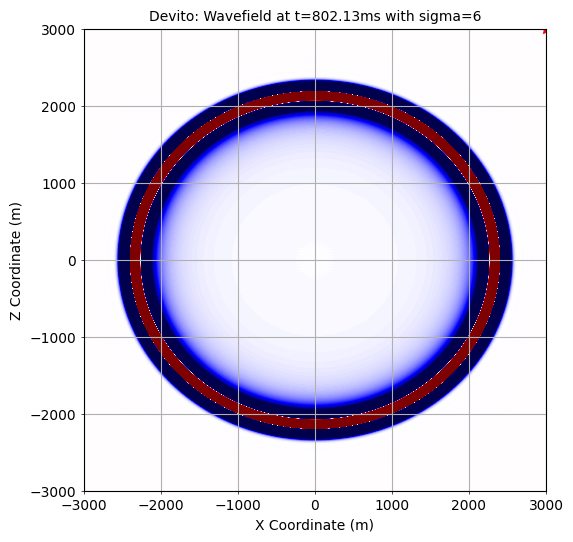

In [109]:
fig, ax = plt.subplots(1)
it =4*factor
ax.imshow(np.transpose(p.data[it,:,:]), cmap="seismic",
            vmin=-amax, vmax=+amax, extent=plt_extent)
ax.plot(model.domain_size[0]* .5, model.domain_size[1]* .5, \
        'red', linestyle='None', marker='*', markersize=8, label="Source")
ax.grid()
ax.tick_params('both', length=2, width=0.5, which='major',labelsize=10)
ax.set_title("Devito: Wavefield at t="+str(format(it*dt, '.2f'))+"ms with sigma="+str(sigma),fontsize=10)
ax.set_xlabel("X Coordinate (m)",fontsize=10)
ax.set_ylabel("Z Coordinate (m)",fontsize=10)
